# Load Libraries


In [1]:
from google.colab import drive
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from skimage.transform import resize


# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
f = sio.loadmat('/content/drive/MyDrive/C19NewSim/Data/XRdataset3000.mat')

inp1= f['selImgs']
inp = np.zeros((3000,64,64))
for ii in range(3000):

  a=inp1[ii]
  a = resize(a,(64,64))
  inp[ii]= (a - np.min(a))/np.ptp(a)*np.pi*2

inp=cp.array(inp)



# Super Gaussian for boundary

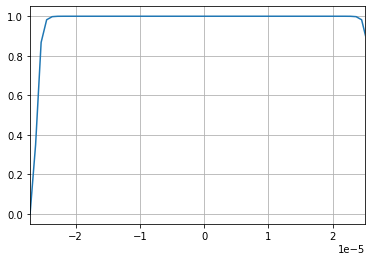

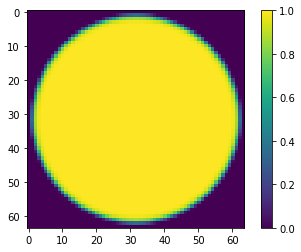

In [3]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1,p=60,w=26.5e-6):
  """define normalized 2D gaussian"""

  return np.exp(-2*((np.sqrt(x**2+y**2)/w)**p))

spacewidth=54.1442e-6

xres=54.1442e-6/64
x = np.linspace(-spacewidth*0.5,spacewidth*0.5,int(spacewidth/xres))

x1, y1 = np.meshgrid(x, x) # get 2D variables instead of 1D
z = gaus2d(x1, y1)

# plt.imshow(z)
# plt.colorbar()

plt.plot(x,z[32,:])
plt.grid()
plt.xlim((-27.0721e-6,25e-6))
plt.show()

cp_super_gauss2d =cp.asarray(z)
cp_super_gauss2d = cp.repeat(cp_super_gauss2d[:,:,cp.newaxis], 2048, axis=2)

plt.imshow(z)
plt.colorbar()
plt.show()



# BPM 


In [6]:
tt = time.time()
c = 299792458 # [m/s]
n0 = 1.44                   # Refractive index of medium
lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]
#k0 = 2*pi/lambda_c         # [1/m]
#k = k0*n0                  # [1/m]

## TIME SPACE DOMAIN
timewidth = 20e-12          # Width of the time window in [s]
tres = timewidth/((2**11))
t = cp.arange(-timewidth*0.5,(timewidth*0.5),tres)
#t = -timewidth*0.5:tres:timewidth*0.5 # Time in [s]
timesteps=len(t)

spacewidth=54.1442e-6
xres = spacewidth/((2**6))
#x = -spacewidth*0.5:xres:spacewidth*0.5 # Time in [s]
x = cp.arange(-spacewidth*0.5,(spacewidth*0.5),xres)
xsteps=len(x)
y = x
[X,Y,T] = cp.meshgrid(x,y,t)

## FOURIER DOMAIN
fs=1/timewidth
freq = c/lambda_c+fs*cp.linspace(-timesteps/2,timesteps/2,num = timesteps)
#freq=c/lambda_c+fs*linspace(-(timesteps-1)/2,(timesteps-1)/2,timesteps) # [Hz]
wave=c/freq # [m]
w=2*cp.pi*c/lambda_c # [Hz]
omegas=2*cp.pi*freq
wt = omegas-w

#kx = 2*pi/xsteps/xres*x;
#kx = 2*pi/xres*x;

#CHECK KX
a = cp.pi/xres  # grid points in "frequency" domain--> {2*pi*(points/mm)}
N = len(x)
zbam = cp.arange(-a,(a-2*a/N)+(2*a/N),2*a/N)
kx = cp.transpose(zbam) # "frequency" domain indexing ky = kx; 
ky = kx
[KX,KY,WT] = cp.meshgrid(kx,ky,wt);
## OPERATORS
k0 = w*n0/c
n2 = 3.2e-20       #Kerr coefficient (m^2/W)
R = 25e-6
beta2 = 24.8e-27
beta3 = 23.3e-42
gamma = (2*cp.pi*n2/(lambda_c))
delta = 0.01
NL1 = -1j*((k0*delta)/(R*R))*((X**2)+(Y**2))

D1 = (0.5*1j/k0)*((-1j*(KX))**2+(-1j*(KY))**2)
D2 = ((-0.5*1j*beta2)*(-1j*(WT))**2)+((beta3/6)*(-1j*(WT))**3)
D = D1 + D2
dz = 555e-6/16
DFR = cp.exp(D*dz/2)

## INPUT 
flength = 555e-6*10
fstep = flength/dz
x_fwhm = 25e-6
t_fwhm = 1e-12
Ppeak = 10e6 # kW

for musti in range(3000):
  slm = inp[musti]
  slm = cp.exp(1j*slm)
  slm2 = cp.repeat(slm[:,:,cp.newaxis], 2048, axis=2)
  A = slm2*cp.sqrt(Ppeak/(cp.pi*x_fwhm*x_fwhm))*cp.exp( - ((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2) + (T**2)/(2*(t_fwhm/2.35482)**2)));
  ### MAIN FUNCTION
  Ain = A
  #Asave = cp.zeros((sampesize,64,64,1024), dtype=complex)


  for ugur in range(int(fstep)):
      #print((ugur*dz)+dz)
      Einf=cp.fft.fftshift(cp.fft.fftn(Ain));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      Eout = Ein2;
      
      NL2 = 1j*gamma*cp.abs(Eout)**2;
      NL = NL1+NL2;
      Eout = Eout*cp.exp(NL*dz);
      
      Einf=cp.fft.fftshift(cp.fft.fftn(Eout));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      #Ain = Ein2;
      Ain =cp.multiply(cp_super_gauss2d,Ein2);
  
  Ain_cpu=Ain.get()  

  sq=np.abs(np.squeeze(np.sum(Ain_cpu,axis=2)))**2

  tot_norm=sq/np.max(sq)

  qq=np.copy(tot_norm)

  #small=qq.reshape([nsmall, nbig//nsmall, nsmall, nbig//nsmall]).mean(3).mean(1)
  small=resize(qq, (22, 22))
  flattened=np.reshape(small,(22*22,))
  sio.savemat('/content/drive/MyDrive/C19NewSim/10MW/data'+str(musti)+'.mat', {'flattened':flattened})
  


elapsed = time.time() - tt
print(elapsed)

9286.42977643013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


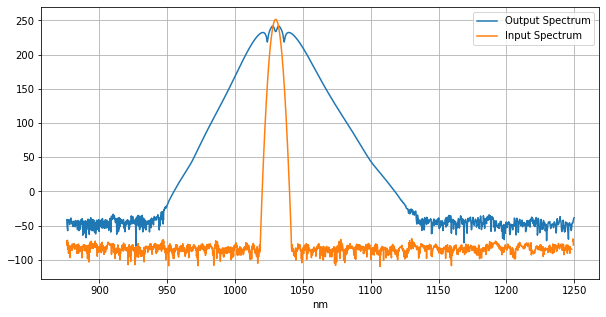

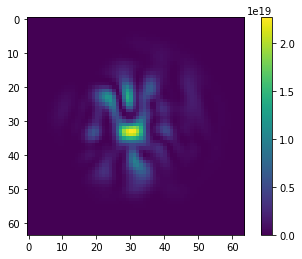

In [7]:
www=wave.get()
s =np.squeeze(np.sum(np.squeeze(np.sum(Ain_cpu,axis=0)),axis=0))
s_in =np.squeeze(np.sum(np.squeeze(np.sum(A.get(),axis=0)),axis=0))
sf=np.fft.fftshift(np.fft.fft(s))
sf_in=np.fft.fftshift(np.fft.fft(s_in))
fig=plt.figure(figsize=(10,5))
plt.plot(www*1e9,10*np.log10(np.abs(sf)**2),label='Output Spectrum')
plt.plot(www*1e9,10*np.log10(np.abs(sf_in)**2),label='Input Spectrum')
plt.legend()
plt.grid()
plt.xlabel('nm')
plt.show()

ampltd =np.sum(Ain_cpu,axis=2)
plt.imshow((np.abs(ampltd)**2))
plt.colorbar()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf


from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Activation, LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

In [9]:
# Load and create normalized intensity images

res_sq_flt=np.zeros((3000,484))
for ugur in range(3000):
  f = sio.loadmat('/content/drive/MyDrive/Optical DNN Project/Revision Covid19/10MW/data'+str(ugur)+'.mat')
  Ain = f['flattened']
  res_sq_flt[ugur] = Ain


sio.savemat('/content/drive/MyDrive/Optical DNN Project/Revision Covid19/10MW/res_sq_flt2_2.mat',{'res_sq_flt':res_sq_flt})

In [10]:
import scipy.io as sio
inp = res_sq_flt

#Load data
f2 = sio.loadmat('/content/drive/MyDrive/Optical DNN Project/Revision Covid19/XRdataset3000.mat')

out = f2['labels']

In [64]:
input_data = inp
output_data = out

print('input_data : ', input_data.shape, input_data.dtype)
print('output_class : ', output_data.shape, output_data.dtype)
print()

input_data :  (3000, 484) float64
output_class :  (3000, 1) uint8



In [65]:
oran = 0.20
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=oran)

print('Test data : ', X_test.shape, X_test.dtype)
print('Training data : ', X_train.shape, X_train.dtype)
print()

Test data :  (600, 484) float64
Training data :  (2400, 484) float64



In [66]:
model = Sequential()
model.add(Dense(1, input_dim=484, activation='sigmoid'))

In [67]:
loss='binary_crossentropy'
metrics = ['accuracy']  # network accuracy metric to be determined after each epoch

opt1 = SGD(lr=0.001, momentum=0.9)
opt2 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt2, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 485       
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________


In [68]:
#setting final parameters for the network and it begins to train
number_of_iterations = 50
batch_size = 50

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_iterations, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5107 - val_loss: 0.6810 - val_accuracy: 0.5767
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.6251 - val_loss: 0.6651 - val_accuracy: 0.6550
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6609 - accuracy: 0.6475 - val_loss: 0.6573 - val_accuracy: 0.6467
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6483 - accuracy: 0.6730 - val_loss: 0.6446 - val_accuracy: 0.6667
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6656 - val_loss: 0.6363 - val_accuracy: 0.6717
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.6612 - val_loss: 0.6269 - val_accuracy: 0.6700
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.6771 - val_loss: 0.6253 - val_accuracy: 0.6783
Epoch 8/50
48/48 [==

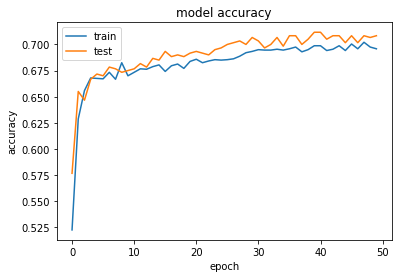

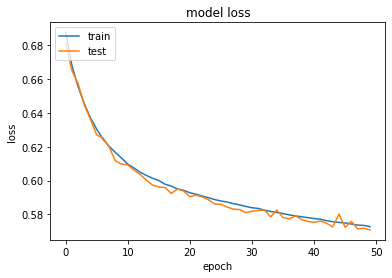

In [69]:
from google.colab import files
ac=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
ac.show()
#ac.savefig('acc-1.png')
#files.download('acc-1.png')

# summarize history for loss
ls=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
ls.show()
#ls.savefig('loss-1.png')
#files.download('loss-1.png')

In [72]:
sio.savemat('/content/drive/MyDrive/Optical DNN Project/Revision Covid19/network_res_10MW.mat', {'y':out, 'X_test':X_test, 'X_train':X_train, 'y_test':y_test, 'y_train':y_train, 'acc':history.history['accuracy'], 'val_acc':history.history['val_accuracy'], 'loss':history.history['loss'], 'val_loss':history.history['val_loss']})

Confusion matrix, without normalization
[[237  89]
 [ 86 188]]


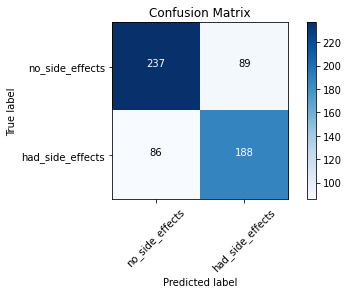

In [71]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm_plot_labels = ['no_side_effects','had_side_effects']
cm = confusion_matrix(y_true=y_test, y_pred=np.round(model.predict(X_test)))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')